# Anti-Money Laundering System

## Problem Statement

Money Laundering is a major challenge in the present highly digitalized economic ecosystem. The fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system. The main objective of this project is to built a machine learning model based on financial transaction data for detecting such fraudulent behavior.

***CRISP-ML(Q)*** process model describes six phases:

1. Business and Data Understanding
2. Data Preparation
3. Model Building
4. Model Evaluation
5. Deployment
6. Monitoring and Maintenance

**Objective(s):** Maximizing the detection of fraud transactions via different channels.

**Constraints:** Minimizing false positives being generated for fraud transactions

# Data Collection

**Data:** This is a synthetic dataset generated using the simulator called PaySim. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

**Dataset:** 
* Our dataset has 6362620 observations about financial transactions.
* And it has 11 variables associated to each transactions. 

**Variables Description:**
* step - Maps a unit of time in the real world(1 step = 1 hour of time).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - Amount of the transaction in local currency.

* nameOrig - Customer who started the transaction.

* oldbalanceOrg - Initial balance before the transaction.

* newbalanceOrig - New balance after the transaction.

* nameDest - Customer who is the recipient of the transaction.

* oldbalanceDest - Initial balance recipient before the transaction.

* newbalanceDest - New balance recipient after the transaction.

* isFraud - This is the transactions made by the fraudulent agents inside the simulation.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt means to transfer more than 200.000 in a single transaction.

>  Note that there is not information for customers that start with M (Merchants).

**Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sweetviz
import dtale
from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split, learning_curve, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from scipy.stats import boxcox, skew, uniform, randint
import lightgbm as lgb
import joblib

**Importing the data**

In [2]:
transaction_details_dataset = pd.read_csv("transaction_details.csv")

In [3]:
transaction_details_dataset.isnull().values.any()

False

In [4]:
print("Our dataset has {} observations and {} columns".format(transaction_details_dataset.shape[0], transaction_details_dataset.shape[1]))

Our dataset has 6362620 observations and 11 columns


In [5]:
transaction_details_dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
transaction_details_dataset.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
transaction_details_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Exploratory Data Analysis (EDA) / Descriptive Statistics

In [8]:
print(transaction_details_dataset.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [9]:
print('Types of fraud transactions: {}'.format(list(transaction_details_dataset.loc[transaction_details_dataset.isFraud == 1].type.drop_duplicates().values)))

fraud_transfer = transaction_details_dataset.loc[(transaction_details_dataset.isFraud == 1) & (transaction_details_dataset.type == 'TRANSFER')]
fraud_cash_out = transaction_details_dataset.loc[(transaction_details_dataset.isFraud == 1) & (transaction_details_dataset.type == 'CASH_OUT')]

print('\nNumber of fraud TRANSFER\'s: {}'.format(len(fraud_transfer)))
print('Number of fraud CASH_OUT\'s: {}'.format(len(fraud_cash_out)))

print('\nPercentage of fraud TRANSFER\'s: {} %'.format((len(fraud_transfer)/len(transaction_details_dataset)) * 100))
print('Percentage of fraud CASH_OUT\'s: {} %'.format((len(fraud_transfer)/len(transaction_details_dataset)) * 100))

Types of fraud transactions: ['TRANSFER', 'CASH_OUT']

Number of fraud TRANSFER's: 4097
Number of fraud CASH_OUT's: 4116

Percentage of fraud TRANSFER's: 0.06439171284785199 %
Percentage of fraud CASH_OUT's: 0.06439171284785199 %


In [10]:
print('Types of transactions which are \'isFlaggedFraud\': {}'.format(list(transaction_details_dataset.loc[transaction_details_dataset.isFlaggedFraud == 1].type.drop_duplicates().values)))

transfer = transaction_details_dataset.loc[(transaction_details_dataset.type == 'TRANSFER')]
is_flagged_fraud = transaction_details_dataset.loc[(transaction_details_dataset.isFlaggedFraud == 1)]
not_flagged_fraud = transaction_details_dataset.loc[(transaction_details_dataset.isFlaggedFraud == 0)]

print('Minimum amount of transaction when \'isFlaggedFraud\' is set: {}'.format(is_flagged_fraud.amount.min()))
print('Maximum amount of transaction in a TRANSFER when \'isFlaggedFraud\' is not set: {}'.format(transfer.loc[(transfer.isFlaggedFraud == 0)].amount.max()))

Types of transactions which are 'isFlaggedFraud': ['TRANSFER']
Minimum amount of transaction when 'isFlaggedFraud' is set: 353874.22
Maximum amount of transaction in a TRANSFER when 'isFlaggedFraud' is not set: 92445516.64


In [11]:
print('Number of TRANSFER\'s where isFlaggedFraud = 1 yet oldbalanceDest = 0, & newbalanceDest = 0: {}'.format(len(transaction_details_dataset.loc[(transaction_details_dataset.isFlaggedFraud == 1) & (transaction_details_dataset.newbalanceDest == 0) & (transaction_details_dataset.oldbalanceDest == 0)])))
print('Number of TRANSFER\'s where isFlaggedFraud = 0 yet oldbalanceDest = 0, & newbalanceDest = 0: {}'.format(len(transaction_details_dataset.loc[(transaction_details_dataset.isFlaggedFraud == 0) & (transaction_details_dataset.newbalanceDest == 0) & (transaction_details_dataset.oldbalanceDest == 0)])))

Number of TRANSFER's where isFlaggedFraud = 1 yet oldbalanceDest = 0, & newbalanceDest = 0: 16
Number of TRANSFER's where isFlaggedFraud = 0 yet oldbalanceDest = 0, & newbalanceDest = 0: 2317266


In [12]:
print('Minimum value of newbalanceOrig when isFlaggedFraud = 0 where oldbalanceOrg = newbalanceOrig: {}'.format(transfer.loc[(transfer.isFlaggedFraud == 0) & (transfer.oldbalanceOrg == transfer.newbalanceOrig)].oldbalanceOrg.min()))
print('Maximum value of newbalanceOrig when isFlaggedFraud = 0 where oldbalanceOrg = newbalanceOrig: {}'.format(transfer.loc[(transfer.isFlaggedFraud == 0) & (transfer.oldbalanceOrg == transfer.newbalanceOrig)].oldbalanceOrg.max()))
print('Minimum value of oldbalanceOrg when isFlaggedFraud = 1: {}'.format(is_flagged_fraud.oldbalanceOrg.min()))
print('Maximum value of oldbalanceOrg when isFlaggedFraud = 1: {}'.format(is_flagged_fraud.oldbalanceOrg.max()))

Minimum value of newbalanceOrig when isFlaggedFraud = 0 where oldbalanceOrg = newbalanceOrig: 0.0
Maximum value of newbalanceOrig when isFlaggedFraud = 0 where oldbalanceOrg = newbalanceOrig: 575667.54
Minimum value of oldbalanceOrg when isFlaggedFraud = 1: 353874.22
Maximum value of oldbalanceOrg when isFlaggedFraud = 1: 19585040.37


In [13]:
print('Any originator of transaction having more than 1 flagged fraud transaction? {}'.format(is_flagged_fraud.nameOrig.isin(pd.concat([not_flagged_fraud.nameOrig, not_flagged_fraud.nameDest])).any()))
print('Any destination for transaction flagged as fraud? {}'.format(is_flagged_fraud.nameDest.isin(not_flagged_fraud.nameOrig).any()))
print('Number of destination accounts flagged fraud were already destination accounts before? {}'.format(sum(is_flagged_fraud.nameDest.isin(not_flagged_fraud.nameDest))))

Any originator of transaction having more than 1 flagged fraud transaction? False
Any destination for transaction flagged as fraud? False
Number of destination accounts flagged fraud were already destination accounts before? 2


In [14]:
print('Any merchants among originator account? {}'.format(transaction_details_dataset.nameOrig.str.contains('M').any()))
print('Are there any transactions having merchants as destination accounts other than \'PAYMENT\' type? {}'.format((transaction_details_dataset.loc[transaction_details_dataset.nameDest.str.contains('M')].type != 'PAYMENT').any()))
print('Any merchants among originator who accounts for \'CASH_IN\' transactions? {}'.format(transaction_details_dataset.loc[transaction_details_dataset.type == 'CASH_IN'].nameOrig.str.contains('M').any()))
print('Any merchants among originator who accounts for \'CASH_OUT\' transactions? {}'.format(transaction_details_dataset.loc[transaction_details_dataset.type == 'CASH_OUT'].nameOrig.str.contains('M').any()))

Any merchants among originator account? False
Are there any transactions having merchants as destination accounts other than 'PAYMENT' type? False
Any merchants among originator who accounts for 'CASH_IN' transactions? False
Any merchants among originator who accounts for 'CASH_OUT' transactions? False


In [15]:
not_fraud = transaction_details_dataset.loc[transaction_details_dataset.isFraud == 0]
print('Fraud TRANSFER"s where destination accounts are originator of "CASH_OUT":\n {}'.format(fraud_transfer.loc[fraud_transfer.nameDest.isin(not_fraud.loc[not_fraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))

Fraud TRANSFER"s where destination accounts are originator of "CASH_OUT":
          step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [16]:
print('Fraud TRANSFER to \'C1714931087\' occurs at step [65] whereas genuine \'CASH_OUT\' from this account occured at step = {}'.format(not_fraud.loc[(not_fraud.type == 'CASH_OUT') & (not_fraud.nameOrig == 'C1714931087')].step.values))
print('Fraud TRANSFER to \'C423543548\' occurs at step [486] whereas genuine \'CASH_OUT\' from this account occured at step = {}'.format(not_fraud.loc[(not_fraud.type == 'CASH_OUT') & (not_fraud.nameOrig == 'C423543548')].step.values))
print('Fraud TRANSFER to \'C1023330867\' occurs at step [738] whereas genuine \'CASH_OUT\' from this account occured at step = {}'.format(not_fraud.loc[(not_fraud.type == 'CASH_OUT') & (not_fraud.nameOrig == 'C1023330867')].step.values))

Fraud TRANSFER to 'C1714931087' occurs at step [65] whereas genuine 'CASH_OUT' from this account occured at step = [546]
Fraud TRANSFER to 'C423543548' occurs at step [486] whereas genuine 'CASH_OUT' from this account occured at step = [185]
Fraud TRANSFER to 'C1023330867' occurs at step [738] whereas genuine 'CASH_OUT' from this account occured at step = [132]


<AxesSubplot:title={'center':'Transaction Type'}>

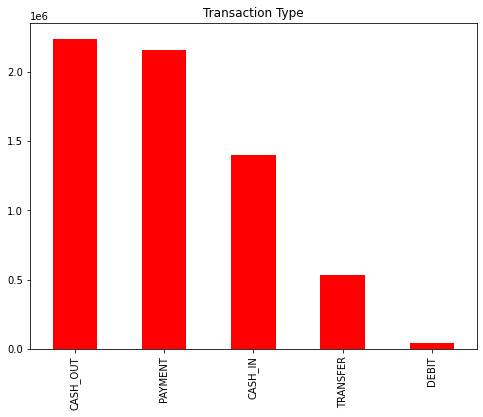

In [17]:
figure, ax = plt.subplots(1, 1, figsize = (8, 6))
transaction_details_dataset.type.value_counts().plot(kind = 'bar', title = 'Transaction Type', color ='red')

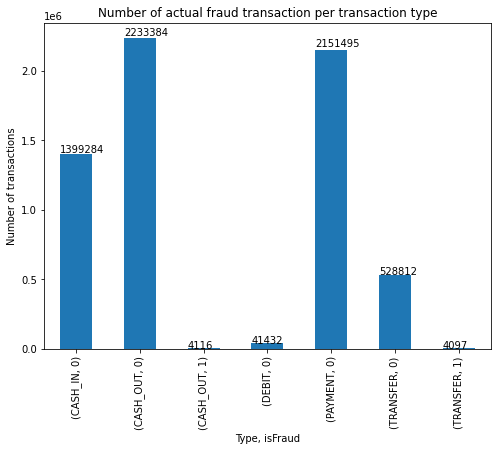

In [18]:
figure, ax = plt.subplots(1, 1, figsize = (8, 6))
ax = transaction_details_dataset.groupby(['type', 'isFraud']).size().plot(kind = 'bar')
ax.set_title('Number of actual fraud transaction per transaction type')
ax.set_xlabel('Type, isFraud')
ax.set_ylabel('Number of transactions')

for x in ax.patches:
    ax.annotate(str(format(int(x.get_height()))), (x.get_x(), x.get_height() * 1.01))

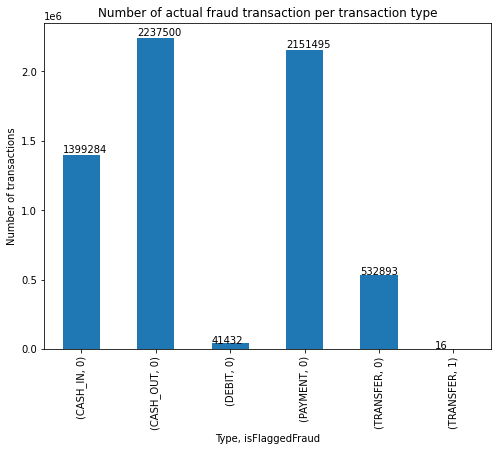

In [19]:
figure, ax = plt.subplots(1, 1, figsize = (8, 6))
ax = transaction_details_dataset.groupby(['type', 'isFlaggedFraud']).size().plot(kind = 'bar')
ax.set_title('Number of actual fraud transaction per transaction type')
ax.set_xlabel('Type, isFlaggedFraud')
ax.set_ylabel('Number of transactions')

for x in ax.patches:
    ax.annotate(str(format(int(x.get_height()))), (x.get_x(), x.get_height() * 1.01))

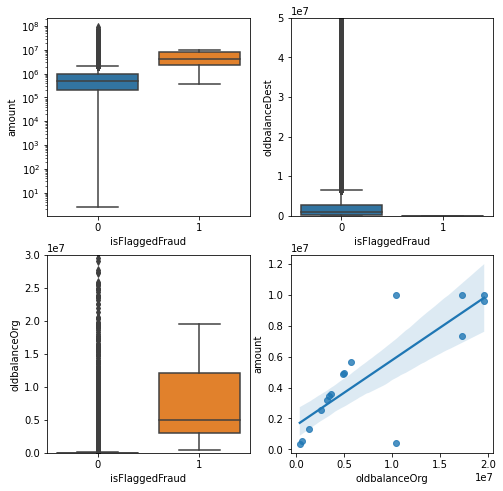

In [20]:
figure, axis = plt.subplots(2, 2, figsize = (8, 8))

figure_1 = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = transfer, ax = axis[0][0])
axis[0][0].set_yscale('log')
figure_2 = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = transfer, ax = axis[0][1])
axis[0][1].set(ylim=(0, 0.5e8))
figure_3 = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data = transfer, ax = axis[1][0])
axis[1][0].set(ylim=(0, 3e7))
figure_4 = sns.regplot(x = 'oldbalanceOrg', y = 'amount', data = transfer.loc[(transaction_details_dataset.isFlaggedFraud == 1)], ax = axis[1][1])
plt.show()

## Data Preprocessing

***'TRANSFER' OR 'CASH_OUT' Transactions***

In [21]:
transfer_or_cash_out = transaction_details_dataset.loc[(transaction_details_dataset.type == 'TRANSFER') | (transaction_details_dataset.type == 'CASH_OUT')]
np.random.seed(5)
print('We have a total of {} transactions that are either \'TRANSFER\' OR \'CASH_OUT\'.'.format(transfer_or_cash_out.shape[0]))

We have a total of 2770409 transactions that are either 'TRANSFER' OR 'CASH_OUT'.


### Automated Library

In [22]:
automated_report = sweetviz.analyze(transfer_or_cash_out)
automated_report.show_html('Report.html')

                                             |                      | [  0%]   00:00 -> (? left)

Report Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [23]:
dataset_visuals = dtale.show(transfer_or_cash_out)
dataset_visuals.open_browser()

**Cleaning Unwanted Columns**

'nameDest', 'nameOrig', 'isFlaggedFraud': These columns are of no relevance for the analytical domain of work, as it does not have any nominal data. Hence, we can ignore them.

In [24]:
transfer_or_cash_out = transfer_or_cash_out.drop(['nameDest', 'nameOrig', 'isFlaggedFraud'], axis = 1)

In [25]:
fraud_transfer_or_cash_out = transfer_or_cash_out.loc[transfer_or_cash_out['isFraud'] == 1]
not_fraud_transfer_or_cash_out = transfer_or_cash_out.loc[transfer_or_cash_out['isFraud'] == 0]

print('Fraction of fraud transactions with \'oldbalanceDest\' = \'newbalanceDest\' after having a non-zero transaction: {}'.format(len(fraud_transfer_or_cash_out.loc[(fraud_transfer_or_cash_out.oldbalanceDest == 0) & (fraud_transfer_or_cash_out.newbalanceDest == 0) & (fraud_transfer_or_cash_out.amount)]) / len(fraud_transfer_or_cash_out)))

Fraction of fraud transactions with 'oldbalanceDest' = 'newbalanceDest' after having a non-zero transaction: 0.4955558261293072


***Computation:***
1. Imputing null values using Mean imputation.
2. Conversion of 'categorical data' to 'numerical data' using LabelEncoder.
3. DataFrameMapper is used to map the given attribute.

In [26]:
numerical_features = transfer_or_cash_out.select_dtypes(include = ['int32', 'int64', 'float32', 'float64']).columns
numerical_features

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [27]:
categorical_features = transfer_or_cash_out.select_dtypes(include = ['object']).columns
categorical_features

Index(['type'], dtype='object')

In [28]:
numerical_pipeline = Pipeline([('impute', SimpleImputer(strategy = 'mean'))])
categorical_pipeline = Pipeline([('label', DataFrameMapper([(categorical_features, LabelEncoder())]))])
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

In [29]:
preprocess_pipeline = ColumnTransformer([('category', categorical_pipeline, categorical_features), 
                                         ('numerical', numerical_pipeline, numerical_features)],
                                        remainder = 'passthrough')
preprocess_fit = preprocess_pipeline.fit(transfer_or_cash_out)
preprocess_fit

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

2023-02-15 12:04:51,979 - INFO     - [FIT_TRANSFORM] Index(['type'], dtype='object'): 0.674528 secs


ColumnTransformer(remainder='passthrough',
                  transformers=[('category',
                                 Pipeline(steps=[('label',
                                                  DataFrameMapper(drop_cols=[],
                                                                  features=[(Index(['type'], dtype='object'),
                                                                             LabelEncoder())]))]),
                                 Index(['type'], dtype='object')),
                                ('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer())]),
                                 Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object'))])

In [30]:
preprocess_transform = preprocess_fit.transform(transfer_or_cash_out)
preprocess_transform

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

2023-02-15 12:04:53,332 - INFO     - [TRANSFORM] Index(['type'], dtype='object'): 0.512919 secs


array([[1.00000000e+00, 1.00000000e+00, 1.81000000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 1.81000000e+02, ...,
        2.11820000e+04, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 2.29133940e+05, ...,
        5.08300000e+03, 5.15134400e+04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 7.43000000e+02, 6.31140928e+06, ...,
        6.84888400e+04, 6.37989811e+06, 1.00000000e+00],
       [1.00000000e+00, 7.43000000e+02, 8.50002520e+05, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 7.43000000e+02, 8.50002520e+05, ...,
        6.51009911e+06, 7.36010163e+06, 1.00000000e+00]])

In [31]:
preprocess_2 = pd.DataFrame(preprocess_transform, columns = [transfer_or_cash_out])
preprocess_2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1.0,1.0,181.00,181.00,0.0,0.00,0.00,1.0
1,0.0,1.0,181.00,181.00,0.0,21182.00,0.00,1.0
2,0.0,1.0,229133.94,15325.00,0.0,5083.00,51513.44,0.0
3,1.0,1.0,215310.30,705.00,0.0,22425.00,0.00,0.0
4,1.0,1.0,311685.89,10835.00,0.0,6267.00,2719172.89,0.0
...,...,...,...,...,...,...,...,...
2770404,0.0,743.0,339682.13,339682.13,0.0,0.00,339682.13,1.0
2770405,1.0,743.0,6311409.28,6311409.28,0.0,0.00,0.00,1.0
2770406,0.0,743.0,6311409.28,6311409.28,0.0,68488.84,6379898.11,1.0
2770407,1.0,743.0,850002.52,850002.52,0.0,0.00,0.00,1.0


## Data Visualization

C:\Users\apoor\AppData\Local\Temp\ipykernel_5828\3746894596.py:6: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\apoor\AppData\Local\Temp\ipykernel_5828\3746894596.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator



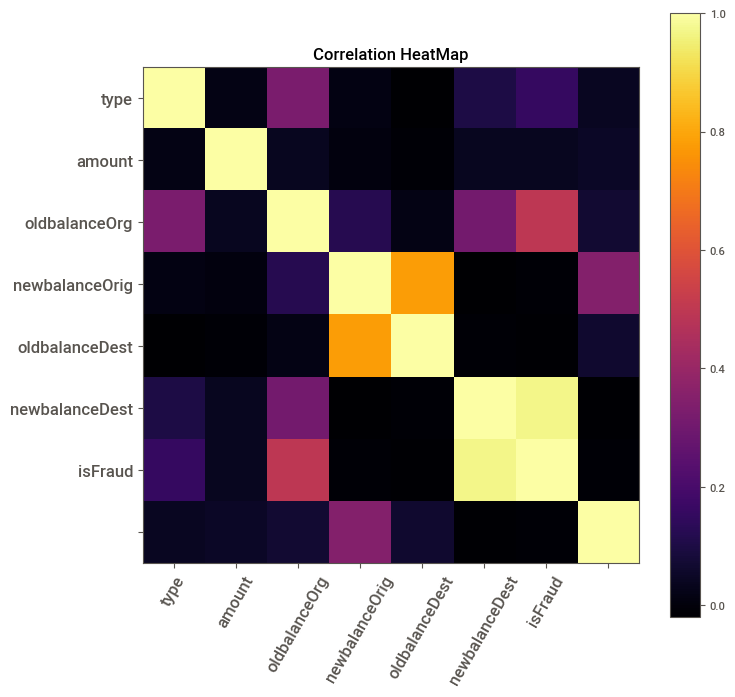

In [32]:
def correlation_plot(dataframe, labels):
    figure, axis = plt.subplots(1, 1, figsize = (8, 8))
    cmap = cm.get_cmap('inferno')
    cax = axis.imshow(dataframe.corr(), cmap = cmap)
    plt.title('Correlation HeatMap')
    axis.set_xticklabels(labels, fontsize = 12, rotation = 60)
    axis.set_yticklabels(labels, fontsize = 12)
    figure.colorbar(cax)
    plt.show()
    
correlation_plot_labels = preprocess_2.columns.tolist()

for i in range(len(correlation_plot_labels)):
    correlation_plot_labels[i] = correlation_plot_labels[i][0]
    
correlation_plot(preprocess_2, correlation_plot_labels)

<AxesSubplot:xlabel='None', ylabel='None'>

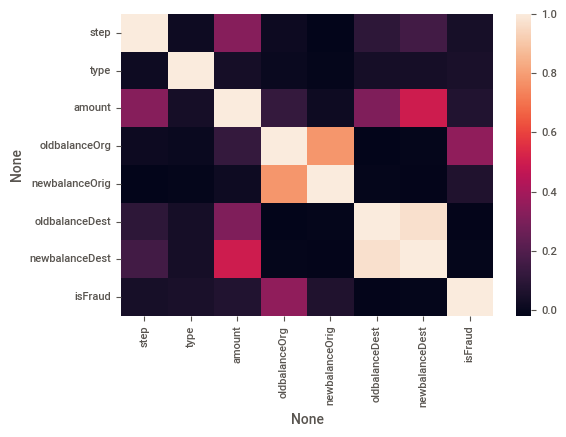

In [33]:
sns.heatmap(preprocess_2.corr())

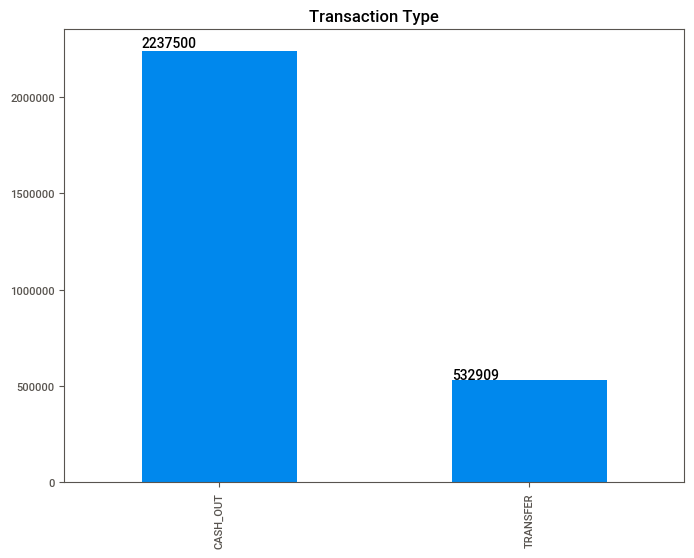

In [34]:
transaction_type_plot = transfer_or_cash_out.type.value_counts().plot(kind = 'bar', title = 'Transaction Type', figsize = (8, 6))

for patch in transaction_type_plot.patches:
    transaction_type_plot.annotate(str(format(int(patch.get_height()))), (patch.get_x(), patch.get_height() * 1.01))

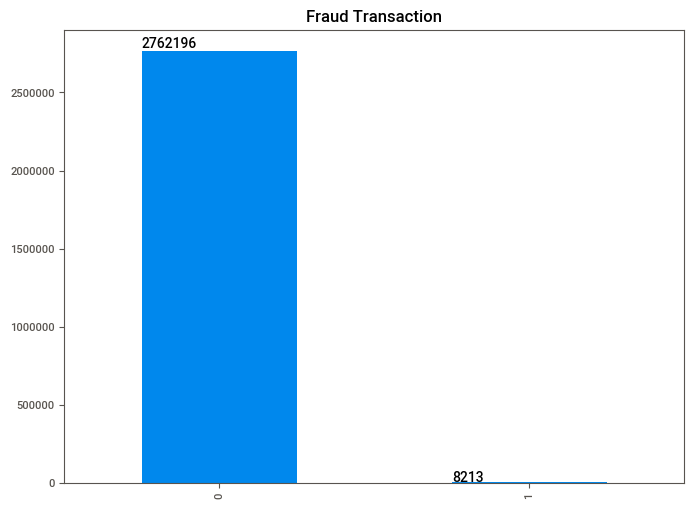

In [35]:
fraud_transaction_plot = pd.value_counts(transfer_or_cash_out['isFraud']).plot(kind = 'bar', title = 'Fraud Transaction', figsize = (8, 6))

for patch in fraud_transaction_plot.patches:
    fraud_transaction_plot.annotate(str(format(int(patch.get_height()))), (patch.get_x(), patch.get_height() * 1.01))

Data visualized above have quite skewed numerical variables. Therefore scaling the data to skew

In [36]:
transfer_or_cash_out['amount_boxcox'] = preprocessing.scale(boxcox(transfer_or_cash_out['amount'] + 1)[0])
transfer_or_cash_out['amount_oldbalanceOrg'] = preprocessing.scale(boxcox(transfer_or_cash_out['oldbalanceOrg'] + 1)[0])
transfer_or_cash_out['amount_newbalanceOrig'] = preprocessing.scale(boxcox(transfer_or_cash_out['newbalanceOrig'] + 1)[0])
transfer_or_cash_out['amount_oldbalanceDest'] = preprocessing.scale(boxcox(transfer_or_cash_out['oldbalanceDest'] + 1)[0])
transfer_or_cash_out['amount_newbalanceDest'] = preprocessing.scale(boxcox(transfer_or_cash_out['newbalanceDest'] + 1)[0])

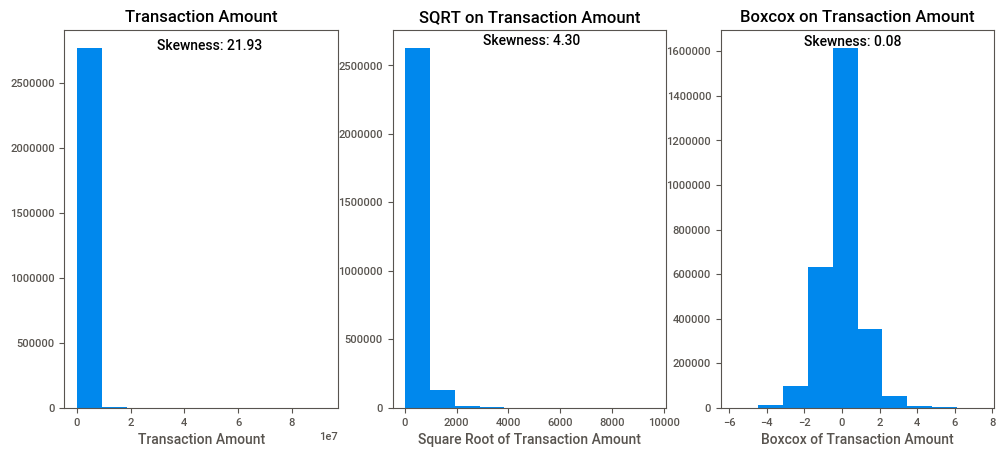

In [37]:
figure, axis = plt.subplots(1, 3, figsize = (12, 5))

axis[0].hist(transfer_or_cash_out['amount'])
axis[0].set_xlabel('Transaction Amount')
axis[0].set_title('Transaction Amount')
axis[0].text(0.3e8, 2750000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount'])))

axis[1].hist(np.sqrt(transfer_or_cash_out['amount']))
axis[1].set_xlabel('Square Root of Transaction Amount')
axis[1].set_title('SQRT on Transaction Amount')
axis[1].text(3000, 2650000, 'Skewness: {:.2f}'.format(skew(np.sqrt(transfer_or_cash_out['amount']))))

axis[2].hist(transfer_or_cash_out['amount_boxcox'])
axis[2].set_xlabel('Boxcox of Transaction Amount')
axis[2].set_title('Boxcox on Transaction Amount')
axis[2].text(-2, 1625000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount_boxcox'])))

plt.show()

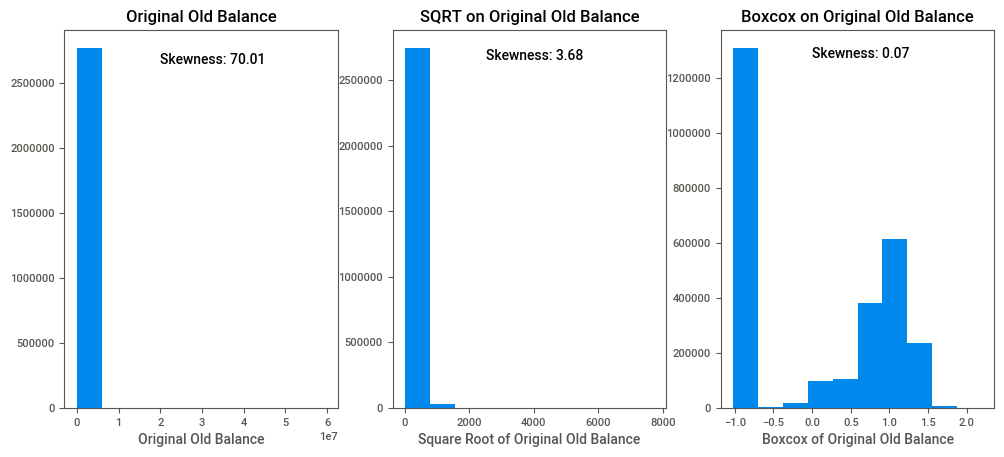

In [38]:
figure, axis = plt.subplots(1, 3, figsize = (12, 5))

axis[0].hist(transfer_or_cash_out['oldbalanceOrg'])
axis[0].set_xlabel('Original Old Balance')
axis[0].set_title('Original Old Balance')
axis[0].text(0.2e8, 2650000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['oldbalanceOrg'])))

axis[1].hist(np.sqrt(transfer_or_cash_out['oldbalanceOrg']))
axis[1].set_xlabel('Square Root of Original Old Balance')
axis[1].set_title('SQRT on Original Old Balance')
axis[1].text(2500, 2650000, 'Skewness: {:.2f}'.format(skew(np.sqrt(transfer_or_cash_out['oldbalanceOrg']))))

axis[2].hist(transfer_or_cash_out['amount_oldbalanceOrg'])
axis[2].set_xlabel('Boxcox of Original Old Balance')
axis[2].set_title('Boxcox on Original Old Balance')
axis[2].text(0, 1275000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount_oldbalanceOrg'])))

plt.show()

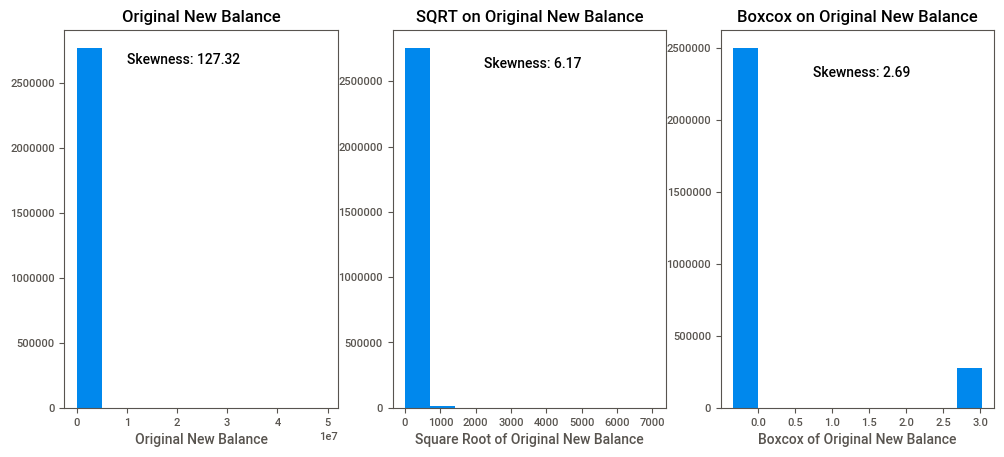

In [39]:
figure, axis = plt.subplots(1, 3, figsize = (12, 5))

axis[0].hist(transfer_or_cash_out['newbalanceOrig'])
axis[0].set_xlabel('Original New Balance')
axis[0].set_title('Original New Balance')
axis[0].text(0.1e8, 2650000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['newbalanceOrig'])))

axis[1].hist(np.sqrt(transfer_or_cash_out['newbalanceOrig']))
axis[1].set_xlabel('Square Root of Original New Balance')
axis[1].set_title('SQRT on Original New Balance')
axis[1].text(2250, 2600000, 'Skewness: {:.2f}'.format(skew(np.sqrt(transfer_or_cash_out['newbalanceOrig']))))

axis[2].hist(transfer_or_cash_out['amount_newbalanceOrig'])
axis[2].set_xlabel('Boxcox of Original New Balance')
axis[2].set_title('Boxcox on Original New Balance')
axis[2].text(0.75, 2300000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount_newbalanceOrig'])))

plt.show()

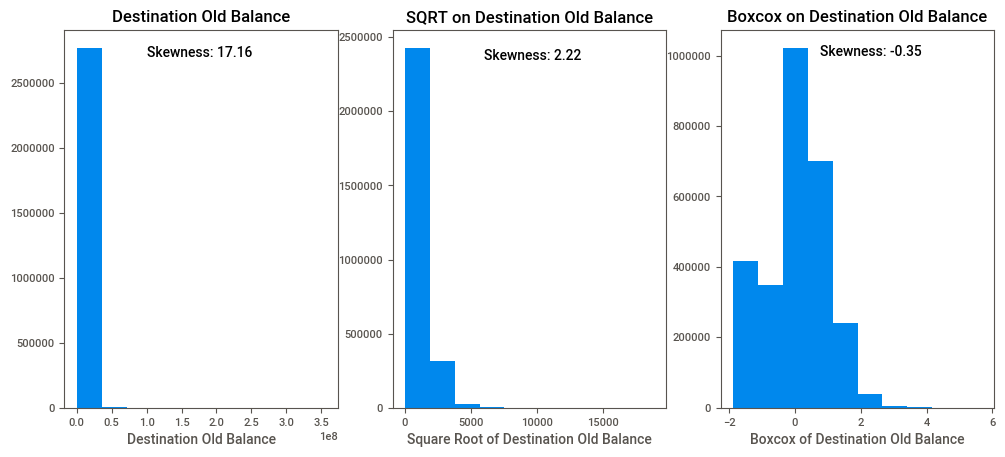

In [40]:
figure, axis = plt.subplots(1, 3, figsize = (12, 5))

axis[0].hist(transfer_or_cash_out['oldbalanceDest'])
axis[0].set_xlabel('Destination Old Balance')
axis[0].set_title('Destination Old Balance')
axis[0].text(0.1e9, 2700000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['oldbalanceDest'])))

axis[1].hist(np.sqrt(transfer_or_cash_out['oldbalanceDest']))
axis[1].set_xlabel('Square Root of Destination Old Balance')
axis[1].set_title('SQRT on Destination Old Balance')
axis[1].text(6000, 2350000, 'Skewness: {:.2f}'.format(skew(np.sqrt(transfer_or_cash_out['oldbalanceDest']))))

axis[2].hist(transfer_or_cash_out['amount_oldbalanceDest'])
axis[2].set_xlabel('Boxcox of Destination Old Balance')
axis[2].set_title('Boxcox on Destination Old Balance')
axis[2].text(0.75, 1000000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount_oldbalanceDest'])))

plt.show()

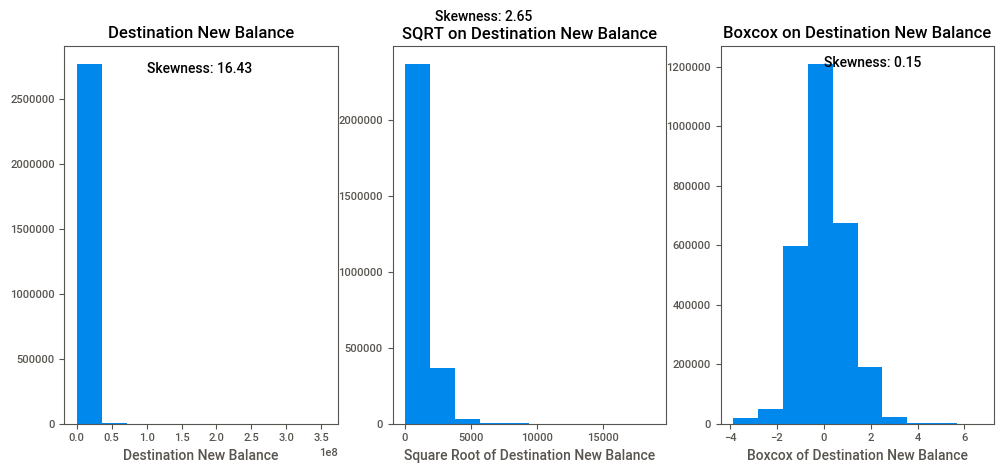

In [41]:
figure, axis = plt.subplots(1, 3, figsize = (12, 5))

axis[0].hist(transfer_or_cash_out['newbalanceDest'])
axis[0].set_xlabel('Destination New Balance')
axis[0].set_title('Destination New Balance')
axis[0].text(0.1e9, 2700000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['newbalanceDest'])))

axis[1].hist(np.sqrt(transfer_or_cash_out['newbalanceDest']))
axis[1].set_xlabel('Square Root of Destination New Balance')
axis[1].set_title('SQRT on Destination New Balance')
axis[1].text(2250, 2650000, 'Skewness: {:.2f}'.format(skew(np.sqrt(transfer_or_cash_out['newbalanceDest']))))

axis[2].hist(transfer_or_cash_out['amount_newbalanceDest'])
axis[2].set_xlabel('Boxcox of Destination New Balance')
axis[2].set_title('Boxcox on Destination New Balance')
axis[2].text(0, 1200000, 'Skewness: {:.2f}'.format(skew(transfer_or_cash_out['amount_newbalanceDest'])))

plt.show()

In [42]:
print('Percentage of fraud transactions of the filtered dataset: {}%'.format((len(transfer_or_cash_out[transfer_or_cash_out['isFraud'] == 1]) / len(transfer_or_cash_out)) * 100))

Percentage of fraud transactions of the filtered dataset: 0.2964544224336551%


As we can observe, there is approximately only 0.3% of the actual fraud data and the remaining unrelevant data has been filtered out.

Now, only boxcox data transformation will be used for the model prediction.

In [43]:
transfer_or_cash_out.drop(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis = 1, inplace = True)

In [44]:
transfer_or_cash_out.reset_index(drop = True, inplace = True)

fraud_record_count = len(transfer_or_cash_out[transfer_or_cash_out['isFraud'] == 1])

fraud_indices = transfer_or_cash_out[transfer_or_cash_out['isFraud'] == 1].index.values
normal_indices = transfer_or_cash_out[transfer_or_cash_out['isFraud'] == 0].index

random_normal_indices = np.array(np.random.choice(normal_indices, fraud_record_count, replace = False))

combine_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
combine_sample_data = transfer_or_cash_out.iloc[combine_sample_indices, :]

not_fraud_undersample = combine_sample_data.loc[:, combine_sample_data.columns != 'isFraud']
is_fraud_undersample = combine_sample_data.loc[:, combine_sample_data.columns == 'isFraud']

print('Percentage of normal transactions: ', len(combine_sample_data[combine_sample_data.isFraud == 0]) / len(combine_sample_data))
print('Percentage of fraud transactions: ', len(combine_sample_data[combine_sample_data.isFraud == 1]) / len(combine_sample_data))
print('Total count of sample transactions data: ', len(combine_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total count of sample transactions data:  16426


## Model Training & Building

Train & Test Data Split

In [45]:
X = transfer_or_cash_out.iloc[:, transfer_or_cash_out.columns != 'isFraud']
y = transfer_or_cash_out.iloc[:, transfer_or_cash_out.columns == 'isFraud']

In [46]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [47]:
undersample_train_x, undersample_test_x, undersample_train_y, undersample_test_y = train_test_split(not_fraud_undersample, is_fraud_undersample, test_size = 0.2, random_state = 5)

### XGBoost Model

In [48]:
weights = sum(y.isFraud == 0) / sum(y.isFraud == 1)
xgboost = XGBClassifier(scale_pos_weight = weights, n_jobs = 8, max_depth = 3)
probability = xgboost.fit(train_x, train_y).predict_proba(test_x)
print('Area under Precision-Recall curve(AUPRC): {}'.format(metrics.average_precision_score(test_y, probability[:, 1])))

Area under Precision-Recall curve(AUPRC): 0.9302065407634015


Important features for the ML model:

Text(0.5, 1.0, 'Order of the Important Features for building the ML model')

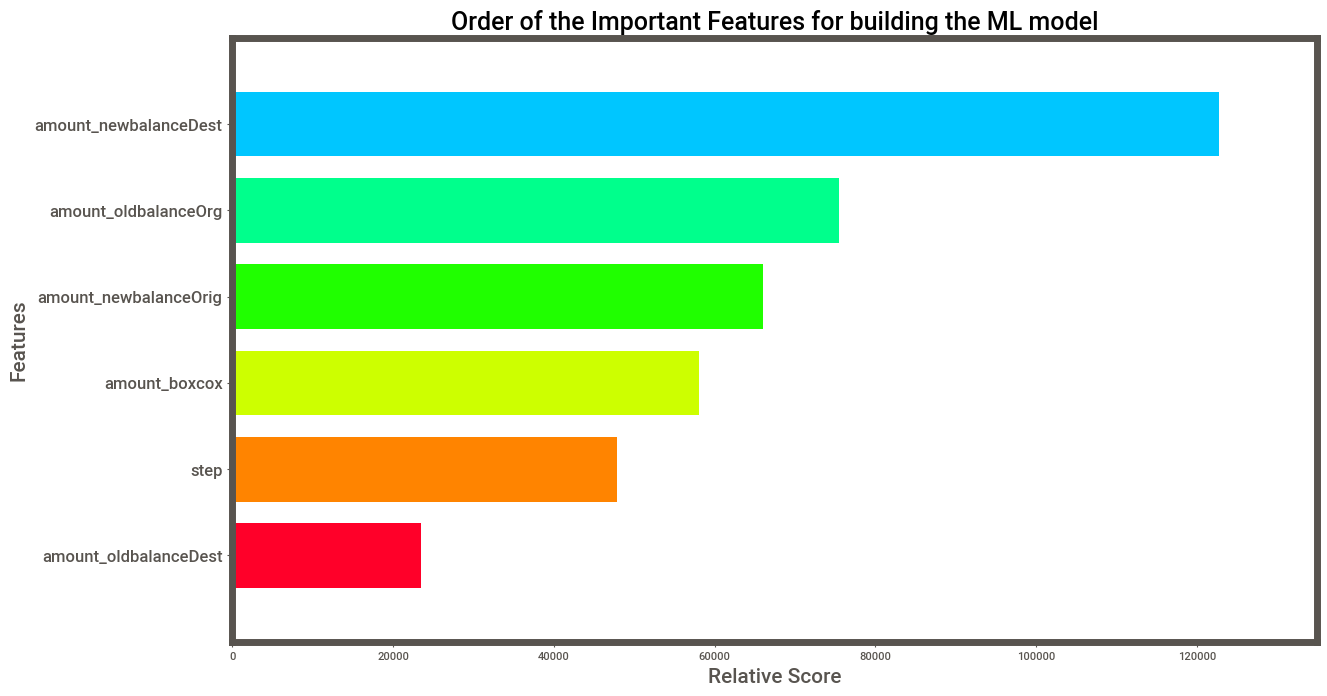

In [49]:
figure = plt.figure(figsize = (14, 8))
axis = figure.add_subplot(1, 1, 1)

line_color = plt.cm.gist_rainbow(np.linspace(0, 1, 9))

axis = plot_importance(xgboost, height = 0.75, grid = False, importance_type = 'cover', ax = axis, show_values = False, color = line_color)

for area in ['top', 'bottom', 'left', 'right']:
    axis.spines[area].set_linewidth(5)

axis.set_xlabel('Relative Score', size = 15)
axis.set_ylabel('Features', size = 15)
axis.set_yticklabels(axis.get_yticklabels(), size = 12)
axis.set_title('Order of the Important Features for building the ML model', size = 18)

In [50]:
train_sizes, train_scores, cross_val_scores = learning_curve(XGBClassifier(scale_pos_weight = weights, n_jobs = 8, max_depth = 3), train_x, train_y, scoring = 'average_precision')

Text(0.5, 1.0, 'Learning Curve Indicates A Good Accuracy Model')

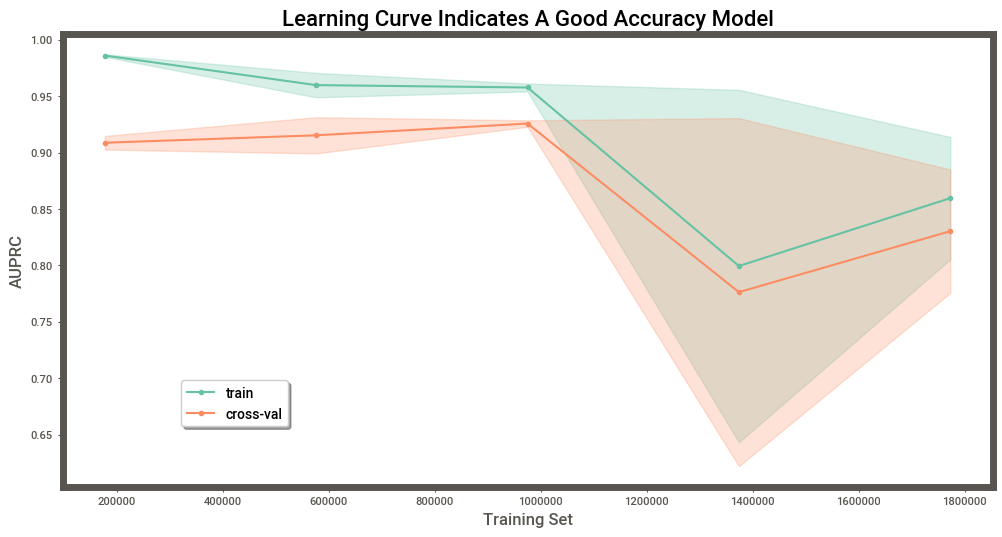

In [51]:
train_scores_mean = np.mean(train_scores, axis = 1)
cross_val_scores_mean = np.mean(cross_val_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)
cross_val_scores_std = np.std(cross_val_scores, axis = 1)

plt_color = plt.cm.Set2(np.linspace(0, 1, 9))

figure = plt.figure(figsize = (12, 6))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.25, color = plt_color[0])
plt.fill_between(train_sizes, cross_val_scores_mean - cross_val_scores_std, cross_val_scores_mean + cross_val_scores_std, alpha = 0.25, color = plt_color[1])
plt.plot(train_sizes, train_scores_mean, 'o-', label = 'train', color = plt_color[0])
plt.plot(train_sizes, cross_val_scores_mean, 'o-', label = 'cross-val', color = plt_color[1])

axis = plt.gca()

for area in ['top', 'bottom', 'left', 'right']:
    axis.spines[area].set_linewidth(5)
    
handles, labels = axis.get_legend_handles_labels()

plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor = (0.25, 0.25), shadow = True)
plt.xlabel('Training Set', size = 12)
plt.ylabel('AUPRC', size = 12)
plt.title('Learning Curve Indicates A Good Accuracy Model', size = 16)

### XGBoost - Binary Classifier

In [52]:
xgb_boost = XGBClassifier(objective = 'binary:logistic')
xgb_boost.fit(undersample_train_x, undersample_train_y.values.ravel())
xgb_boost_predict = xgb_boost.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, xgb_boost_predict)))

Accuracy: 0.9930006086427268


In [53]:
xgb_boost_train_predict = xgb_boost.predict(undersample_train_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_train_y, xgb_boost_train_predict)))

Accuracy: 0.9996955859969558


Check for Overfitting

In [54]:
print('Training Set Score: {}'.format(xgb_boost.score(undersample_train_x, undersample_train_y)))
print('Testing Set Score: {}'.format(xgb_boost.score(undersample_test_x, undersample_test_y)))

Training Set Score: 0.9996955859969558
Testing Set Score: 0.9930006086427268


Confusion Matrix

In [55]:
xgb_regression_ConfusionMatrix = metrics.confusion_matrix(undersample_test_y, xgb_boost_predict)

print('Confusion Matrix:\n', xgb_regression_ConfusionMatrix)

print('\nTrue Positive[TP]: {}'.format(xgb_regression_ConfusionMatrix[0, 0]))
print('False Positive[FP]: {}'.format(xgb_regression_ConfusionMatrix[0, 1]))
print('False Negative[FN]: {}'.format(xgb_regression_ConfusionMatrix[1, 0]))
print('True Negative[TN]: {}'.format(xgb_regression_ConfusionMatrix[1, 1]))

Confusion Matrix:
 [[1625   14]
 [   9 1638]]

True Positive[TP]: 1625
False Positive[FP]: 14
False Negative[FN]: 9
True Negative[TN]: 1638


<AxesSubplot:>

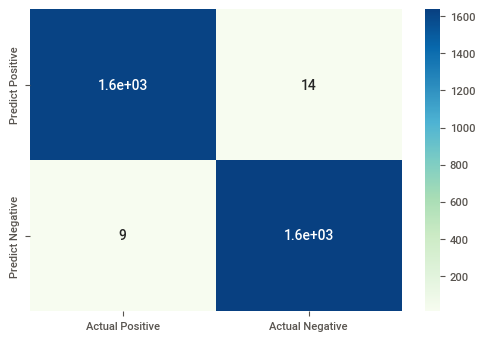

In [56]:
xgb_regression_confusion_matrix_plot = pd.DataFrame(data = xgb_regression_ConfusionMatrix, columns = ['Actual Positive', 'Actual Negative'],
                                    index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(xgb_regression_confusion_matrix_plot, annot = True, cmap = 'GnBu')

Classification Metrics

In [57]:
print(metrics.classification_report(undersample_test_y, xgb_boost_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1639
           1       0.99      0.99      0.99      1647

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



Optimal Hyperparameter Tuning for Ideal XGBoost Model

In [58]:
parameter = {
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5),
    'learning_rate': uniform(0.05, 0.25),
    'max_depth': randint(2, 6),
    'n_estimators': randint(100, 150),
    'subsample': uniform(0.6, 0.4)
}

In [59]:
random_search_cv = RandomizedSearchCV(xgb_boost, param_distributions = parameter, n_iter = 200, cv = 3, verbose = 1, n_jobs = 2, return_train_score = True)
random_search_cv.fit(undersample_test_x, undersample_test_y)

for i in range(1, 5):
    candidates = np.flatnonzero(random_search_cv.cv_results_['rank_test_score'] == i)
    for candidate in candidates:
        print('Model\'s Rank: {}'.format(i))
        print('Mean Validation Score: {} ; Standard Deviation Score: {}'.format(random_search_cv.cv_results_['mean_test_score'][candidate], random_search_cv.cv_results_['std_test_score'][candidate]))
        print('Parameter: {}'.format(random_search_cv.cv_results_['params'][candidate]))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model's Rank: 1
Mean Validation Score: 0.9860011221100112 ; Standard Deviation Score: 0.0018772189228910459
Parameter: {'colsample_bytree': 0.8591089292465529, 'gamma': 0.1796483627512524, 'learning_rate': 0.127133516569588, 'max_depth': 4, 'n_estimators': 122, 'subsample': 0.9777473821524165}
Model's Rank: 2
Mean Validation Score: 0.9853928496039286 ; Standard Deviation Score: 0.0026869155993997085
Parameter: {'colsample_bytree': 0.8613486816266389, 'gamma': 0.431642903989012, 'learning_rate': 0.2665538330169796, 'max_depth': 4, 'n_estimators': 134, 'subsample': 0.7275183002450485}
Model's Rank: 3
Mean Validation Score: 0.9853922941039229 ; Standard Deviation Score: 0.0026899329645635964
Parameter: {'colsample_bytree': 0.8554417671097303, 'gamma': 0.49997065547581887, 'learning_rate': 0.10394604195805983, 'max_depth': 4, 'n_estimators': 116, 'subsample': 0.9929890383032162}
Model's Rank: 4
Mean Validation Score: 0.98539201

In [60]:
ideal_xgb_boost = XGBClassifier(objective = 'binary:logistic', eval_metric = ['auc'], n_estimators = 20)
ideal_xgb_boost.fit(undersample_train_x, undersample_train_y.values.ravel(), early_stopping_rounds = 5, eval_set = [(undersample_test_x, undersample_test_y)])
ideal_xgb_boost_predict = ideal_xgb_boost.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, ideal_xgb_boost_predict)))

print('\nBest Score: {}\nBest Iteration: {}\nBest ntree limit: {}'.format(ideal_xgb_boost.best_score, ideal_xgb_boost.best_iteration, ideal_xgb_boost.best_ntree_limit))

[0]	validation_0-auc:0.99108
[1]	validation_0-auc:0.99270
[2]	validation_0-auc:0.99448
[3]	validation_0-auc:0.99489
[4]	validation_0-auc:0.99548
[5]	validation_0-auc:0.99649
[6]	validation_0-auc:0.99705
[7]	validation_0-auc:0.99740
[8]	validation_0-auc:0.99760
[9]	validation_0-auc:0.99764
[10]	validation_0-auc:0.99766
[11]	validation_0-auc:0.99766
[12]	validation_0-auc:0.99751
[13]	validation_0-auc:0.99749
[14]	validation_0-auc:0.99737
Accuracy: 0.9890444309190505

Best Score: 0.9976585823763731
Best Iteration: 10
Best ntree limit: 11


C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



### Random Forest Classifier Model

In [61]:
random_forest_classifier = RandomForestClassifier(n_estimators = 100)
random_forest_classifier.fit(undersample_train_x, undersample_train_y.values.ravel())
random_forest_classifier_predict = random_forest_classifier.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, random_forest_classifier_predict)))

Accuracy: 0.9896530736457699


In [62]:
random_forest_classifier_train_predict = random_forest_classifier.predict(undersample_train_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_train_y, random_forest_classifier_train_predict)))

Accuracy: 1.0


Check for Overfitting

In [63]:
print('Training Set Score: {}'.format(random_forest_classifier.score(undersample_train_x, undersample_train_y)))
print('Testing Set Score: {}'.format(random_forest_classifier.score(undersample_test_x, undersample_test_y)))

Training Set Score: 1.0
Testing Set Score: 0.9896530736457699


Confusion Matrix

In [64]:
RFC_ConfusionMatrix = metrics.confusion_matrix(undersample_test_y, random_forest_classifier_predict)

print('Confusion Matrix:\n', RFC_ConfusionMatrix)

print('\nTrue Positive[TP]: {}'.format(RFC_ConfusionMatrix[0, 0]))
print('False Positive[FP]: {}'.format(RFC_ConfusionMatrix[0, 1]))
print('False Negative[FN]: {}'.format(RFC_ConfusionMatrix[1, 0]))
print('True Negative[TN]: {}'.format(RFC_ConfusionMatrix[1, 1]))

Confusion Matrix:
 [[1618   21]
 [  13 1634]]

True Positive[TP]: 1618
False Positive[FP]: 21
False Negative[FN]: 13
True Negative[TN]: 1634


<AxesSubplot:>

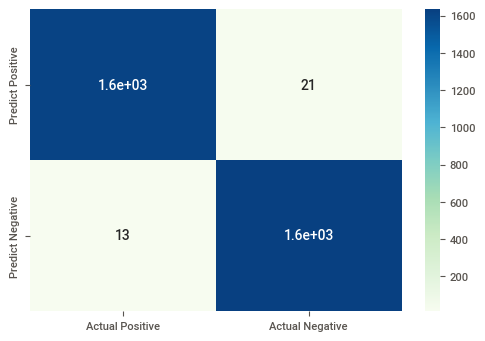

In [65]:
rfc_confusion_matrix_plot = pd.DataFrame(data = RFC_ConfusionMatrix, columns = ['Actual Positive', 'Actual Negative'],
                                    index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(rfc_confusion_matrix_plot, annot = True, cmap = 'GnBu')

Classification Metrics

In [66]:
print(metrics.classification_report(undersample_test_y, random_forest_classifier_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1639
           1       0.99      0.99      0.99      1647

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



### LightGBM Model

In [67]:
lightGBM_model = lgb.LGBMClassifier()
lightGBM_model.fit(undersample_train_x, undersample_train_y.values.ravel())
lightGBM_model_predict = lightGBM_model.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, lightGBM_model_predict)))

Accuracy: 0.9930006086427268


In [68]:
lightGBM_model_train_predict = lightGBM_model.predict(undersample_train_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_train_y, lightGBM_model_train_predict)))

Accuracy: 0.9992389649923896


Check for Overfitting

In [69]:
print('Training Set Score: {}'.format(lightGBM_model.score(undersample_train_x, undersample_train_y)))
print('Testing Set Score: {}'.format(lightGBM_model.score(undersample_test_x, undersample_test_y)))

Training Set Score: 0.9992389649923896
Testing Set Score: 0.9930006086427268


Confusion Matrix

In [70]:
LGBM_ConfusionMatrix = metrics.confusion_matrix(undersample_test_y, lightGBM_model_predict)

print('Confusion Matrix:\n', LGBM_ConfusionMatrix)

print('\nTrue Positive[TP]: {}'.format(LGBM_ConfusionMatrix[0, 0]))
print('False Positive[FP]: {}'.format(LGBM_ConfusionMatrix[0, 1]))
print('False Negative[FN]: {}'.format(LGBM_ConfusionMatrix[1, 0]))
print('True Negative[TN]: {}'.format(LGBM_ConfusionMatrix[1, 1]))

Confusion Matrix:
 [[1624   15]
 [   8 1639]]

True Positive[TP]: 1624
False Positive[FP]: 15
False Negative[FN]: 8
True Negative[TN]: 1639


<AxesSubplot:>

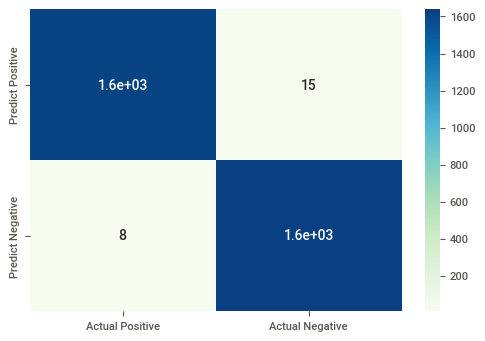

In [71]:
lgbm_confusion_matrix_plot = pd.DataFrame(data = LGBM_ConfusionMatrix, columns = ['Actual Positive', 'Actual Negative'],
                                    index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(lgbm_confusion_matrix_plot, annot = True, cmap = 'GnBu')

Classification Metrics

In [72]:
print(metrics.classification_report(undersample_test_y, lightGBM_model_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1639
           1       0.99      1.00      0.99      1647

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



### Logistic Regression

In [73]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(undersample_train_x, undersample_train_y.values.ravel())
logistic_regression_model_predict = logistic_regression_model.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, logistic_regression_model_predict)))

Accuracy: 0.9433962264150944


C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [74]:
k_fold = StratifiedKFold(5)
cross_validation_score = cross_val_score(logistic_regression_model, undersample_train_x, undersample_train_y.values.ravel(), cv = k_fold, scoring = 'recall')

print('Average Recall Score across Validation Set: {}'.format(np.mean(cross_validation_score)))

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Average Recall Score across Validation Set: 0.9584225651226872


C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Check for Overfitting

In [75]:
print('Training Set Score: {}'.format(logistic_regression_model.score(undersample_train_x, undersample_train_y)))
print('Testing Set Score: {}'.format(logistic_regression_model.score(undersample_test_x, undersample_test_y)))

Training Set Score: 0.9379756468797564
Testing Set Score: 0.9433962264150944


Confusion Matrix

In [76]:
logistic_regression_ConfusionMatrix = metrics.confusion_matrix(undersample_test_y, logistic_regression_model_predict)

print('Confusion Matrix:\n', logistic_regression_ConfusionMatrix)

print('\nTrue Positive[TP]: {}'.format(logistic_regression_ConfusionMatrix[0, 0]))
print('False Positive[FP]: {}'.format(logistic_regression_ConfusionMatrix[0, 1]))
print('False Negative[FN]: {}'.format(logistic_regression_ConfusionMatrix[1, 0]))
print('True Negative[TN]: {}'.format(logistic_regression_ConfusionMatrix[1, 1]))

Confusion Matrix:
 [[1518  121]
 [  65 1582]]

True Positive[TP]: 1518
False Positive[FP]: 121
False Negative[FN]: 65
True Negative[TN]: 1582


<AxesSubplot:>

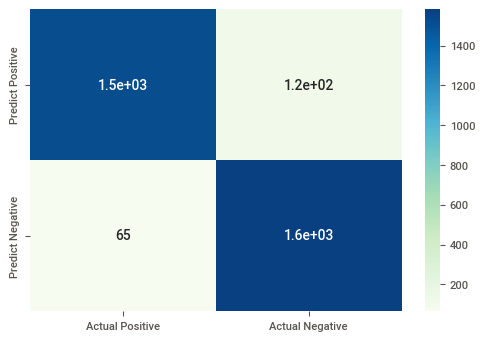

In [77]:
logistic_regression_confusion_matrix_plot = pd.DataFrame(data = logistic_regression_ConfusionMatrix, columns = ['Actual Positive', 'Actual Negative'],
                                    index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(logistic_regression_confusion_matrix_plot, annot = True, cmap = 'GnBu')

In [78]:
print(metrics.classification_report(undersample_test_y, logistic_regression_model_predict))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1639
           1       0.93      0.96      0.94      1647

    accuracy                           0.94      3286
   macro avg       0.94      0.94      0.94      3286
weighted avg       0.94      0.94      0.94      3286



Optimal Hyperparameter Tuning for Ideal Logistic Regression

In [79]:
parameter = [
    {'penalty': ['l1', 'l2'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
     'max_iter': [100, 150, 500, 1000]
    }
]

In [80]:
lr_grid_search_cv = GridSearchCV(logistic_regression_model, param_grid = parameter, cv = 3)
lr_grid_search_cv_fit = lr_grid_search_cv.fit(undersample_train_x.values, undersample_train_y.values.ravel())
lr_grid_search_cv_fit

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\apoor\AppData\Local\Progra

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': [100, 150, 500, 1000],
                          'penalty': ['l1', 'l2'],
                          'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag',
                                     'saga']}])

In [81]:
print('Best Parameter for Logistic Regression: {}'.format(lr_grid_search_cv_fit.best_params_))

Best Parameter for Logistic Regression: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}


In [82]:
print('Accuracy: {}'.format(lr_grid_search_cv_fit.score(undersample_train_x.values, undersample_train_y.values)))

Accuracy: 0.9386605783866058


Area Under Curve(AUC) - Evaluation Metric

AUC Value: 0.986163390608324


C:\Users\apoor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Text(0, 0.5, 'True Positive Rate')

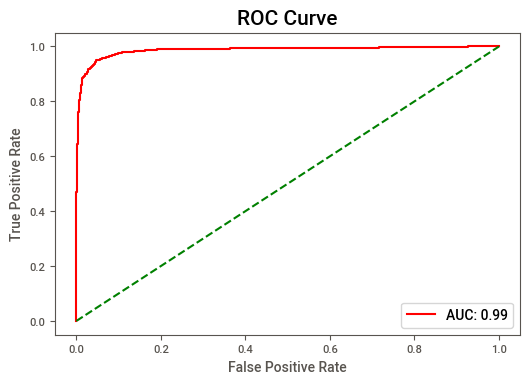

In [83]:
ideal_logistic_regression_model = LogisticRegression(C = 100, penalty = 'l2', solver = 'lbfgs', max_iter = 500)
ideal_logistic_regression_model_fit = ideal_logistic_regression_model.fit(undersample_train_x.values, undersample_train_y.values.ravel()).decision_function(undersample_test_x.values)
ideal_logistic_regression_model_predict = ideal_logistic_regression_model.predict(undersample_test_x)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(undersample_test_y.values.ravel(), ideal_logistic_regression_model_fit)
roc_auc_lr = metrics.auc(false_positive_rate, true_positive_rate)
print('AUC Value: {}'.format(roc_auc_lr))

plt.title('ROC Curve', size = 15)
plt.plot(false_positive_rate, true_positive_rate, 'r', label = 'AUC: {:0.2f}'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], 'g--')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Decision Trees 

In [84]:
decision_tree_classifier_model = DecisionTreeClassifier()
decision_tree_classifier_model.fit(undersample_train_x, undersample_train_y.values.ravel())
decision_tree_classifier_model_predict = decision_tree_classifier_model.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, decision_tree_classifier_model_predict)))

Accuracy: 0.9863055386488131


In [85]:
decision_tree_classifier_model_train_predict = decision_tree_classifier_model.predict(undersample_train_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_train_y, decision_tree_classifier_model_train_predict)))

Accuracy: 1.0


Check for Overfitting

In [86]:
print('Training Set Score: {}'.format(decision_tree_classifier_model.score(undersample_train_x, undersample_train_y)))
print('Testing Set Score: {}'.format(decision_tree_classifier_model.score(undersample_test_x, undersample_test_y)))

Training Set Score: 1.0
Testing Set Score: 0.9863055386488131


Confusion Matrix

In [87]:
decision_tree_ConfusionMatrix = metrics.confusion_matrix(undersample_test_y, decision_tree_classifier_model_predict)

print('Confusion Matrix:\n', decision_tree_ConfusionMatrix)

print('\nTrue Positive[TP]: {}'.format(decision_tree_ConfusionMatrix[0, 0]))
print('False Positive[FP]: {}'.format(decision_tree_ConfusionMatrix[0, 1]))
print('False Negative[FN]: {}'.format(decision_tree_ConfusionMatrix[1, 0]))
print('True Negative[TN]: {}'.format(decision_tree_ConfusionMatrix[1, 1]))

Confusion Matrix:
 [[1618   21]
 [  24 1623]]

True Positive[TP]: 1618
False Positive[FP]: 21
False Negative[FN]: 24
True Negative[TN]: 1623


<AxesSubplot:>

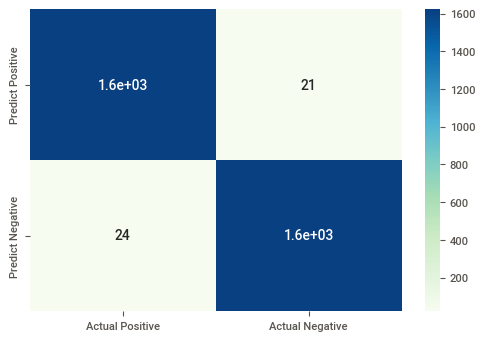

In [88]:
decision_tree_confusion_matrix_plot = pd.DataFrame(data = decision_tree_ConfusionMatrix, columns = ['Actual Positive', 'Actual Negative'],
                                    index = ['Predict Positive', 'Predict Negative'])
sns.heatmap(decision_tree_confusion_matrix_plot, annot = True, cmap = 'GnBu')

Classification Metrics

In [89]:
print(metrics.classification_report(undersample_test_y, decision_tree_classifier_model_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1639
           1       0.99      0.99      0.99      1647

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



Area Under Curve(AUC) - Evaluation Metric

In [90]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(undersample_test_y.values.ravel(), decision_tree_classifier_model_predict)
roc_auc_decision_tree = metrics.auc(false_positive_rate, true_positive_rate)
print('AUC Value: {}'.format(roc_auc_decision_tree))

AUC Value: 0.986307680168391


Optimal Hyperparameter Tuning for Ideal Decision Tree 

In [91]:
parameter = [
    {'max_depth': np.linspace(1, 32, 32, endpoint = True),
     'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint = True),
     'min_samples_split': np.linspace(0.25, 1.0, 10, endpoint = True),
     'max_features': list(range(1, undersample_train_x.shape[1]))
    }
]

In [92]:
decision_tree_grid_search_cv = GridSearchCV(decision_tree_classifier_model, param_grid = parameter, cv = 3)
decision_tree_grid_search_cv_fit = decision_tree_grid_search_cv.fit(undersample_train_x.values, undersample_train_y.values.ravel())
decision_tree_grid_search_cv_fit

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.]),
                          'max_features': [1, 2, 3, 4, 5],
                          'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                          'min_samples_split': array([0.25      , 0.33333333, 0.41666667, 0.5       , 0.58333333,
       0.66666667, 0.75      , 0.83333333, 0.91666667, 1.        ])}])

In [93]:
print('Best Parameter for Decision Tree: {}'.format(decision_tree_grid_search_cv_fit.best_params_))

Best Parameter for Decision Tree: {'max_depth': 27.0, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5}


In [94]:
print('Accuracy: {}'.format(decision_tree_grid_search_cv_fit.score(undersample_train_x.values, undersample_train_y.values)))

Accuracy: 0.8404109589041096


Area Under Curve(AUC) - Evaluation Metric

In [95]:
ideal_decision_tree_classifier_model = DecisionTreeClassifier(max_depth = 18.0, max_features = 3, min_samples_leaf = 0.1, min_samples_split = 0.3333333333333333)
ideal_decision_tree_classifier_model.fit(undersample_train_x, undersample_train_y.values.ravel())
ideal_decision_tree_classifier_model_predict = ideal_decision_tree_classifier_model.predict(undersample_test_x)

print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, ideal_decision_tree_classifier_model_predict)))

Accuracy: 0.8870967741935484


## Summary

### XGBoost Model - Binary Classifier

In [96]:
print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, ideal_xgb_boost_predict)))

Accuracy: 0.9890444309190505


### Random Forest Classifier 

In [97]:
print('Accuracy of Random Forest Classifier: {}'.format(metrics.accuracy_score(undersample_test_y, random_forest_classifier_predict)))

Accuracy of Random Forest Classifier: 0.9896530736457699


### LightGBM Model

In [98]:
print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, lightGBM_model_predict)))

Accuracy: 0.9930006086427268


### Logistic Regression

In [99]:
print('Accuracy : {}'.format(metrics.accuracy_score(undersample_test_y, ideal_logistic_regression_model_predict)))

Accuracy : 0.9433962264150944


### Decision Trees

In [100]:
print('Accuracy: {}'.format(metrics.accuracy_score(undersample_test_y, decision_tree_classifier_model_predict)))

Accuracy: 0.9863055386488131


## *******************************************
### Best Model - LightGBM(99.3% accuracy)
## *******************************************

## Saving The Model

In [101]:
joblib.dump(lightGBM_model, 'Streamlit_Deployment\\lightGBM_model.sav')

['lightGBM_model.sav']